# Excercise 2: Murnaghan plots using sphinx

In [1]:
from pyiron import Project
import numpy as np
import matplotlib.pylab as plt

In [2]:
import pandas as pd
from ast import literal_eval

In [3]:
pr = Project("sphinx_demo")
pr.remove_jobs()

In [4]:
job_sphinx = pr.create_job(pr.job_type.Sphinx, "test_sphinx")

In [5]:
job_sphinx.structure = pr.create_ase_bulk("Al")

In [6]:
job_sphinx.plane_wave_cutoff

340

In [7]:
job_sphinx.set_kpoints(mesh=[5, 5, 5])

In [8]:
job_sphinx.input

,Parameter,Value,Comment
0,EnCut,340,
1,KpointCoords,"[0.5, 0.5, 0.5]",
2,KpointFolding,"[5, 5, 5]",
3,EmptyStates,auto,
4,Sigma,0.2,
5,Xcorr,PBE,
6,VaspPot,False,
7,Estep,400,
8,Ediff,1.0e-4,
9,WriteWaves,True,


In [9]:
job_sphinx.calc_static()

In [10]:
job_sphinx.run()

The job test_sphinx was saved and received the ID: 1
The files are already compressed!


In [11]:
job_sphinx.status

'finished'

In [12]:
job_sphinx["output/generic"]

{'groups': ['dft'], 'nodes': ['cells', 'computation_time', 'energy_pot', 'energy_tot', 'forces', 'positions', 'volume']}

In [13]:
job_sphinx["output/generic/energy_tot"][-1]

-57.24482925575225

In [14]:
pr = Project("murnaghan_Al_dft")
pr.remove_jobs()

In [15]:
a_range = np.linspace(3.9, 4.2, 6)
encut_list = [350]
kpoint_list = [12]

In [16]:
for kpt in kpoint_list:
    for encut in encut_list:
        for a in a_range:
            job_name = "job_name_a_{:.4}_encut_{}_kpt_{}".format(a, encut, kpt).replace(".", "_")
            print(job_name)
            job = pr.create_job(pr.job_type.Sphinx, job_name)
            job.structure = pr.create_ase_bulk("Al", a=a)
            job.plane_wave_cutoff = encut
            k_mesh = [kpt] * 3
            job.set_kpoints(mesh=k_mesh)
            job.run()
        

job_name_a_3_9_encut_350_kpt_12
The job job_name_a_3_9_encut_350_kpt_12 was saved and received the ID: 2
The files are already compressed!
job_name_a_3_96_encut_350_kpt_12
The job job_name_a_3_96_encut_350_kpt_12 was saved and received the ID: 3
The files are already compressed!
job_name_a_4_02_encut_350_kpt_12
The job job_name_a_4_02_encut_350_kpt_12 was saved and received the ID: 4
The files are already compressed!
job_name_a_4_08_encut_350_kpt_12
The job job_name_a_4_08_encut_350_kpt_12 was saved and received the ID: 5
The files are already compressed!
job_name_a_4_14_encut_350_kpt_12
The job job_name_a_4_14_encut_350_kpt_12 was saved and received the ID: 6
The files are already compressed!
job_name_a_4_2_encut_350_kpt_12
The job job_name_a_4_2_encut_350_kpt_12 was saved and received the ID: 7
The files are already compressed!


In [17]:
pr.job_table();

In [18]:
# Loading a job
%time
job = pr.load("job_name_a_3_9_encut_350_kpt_12")
job["input/structure"]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.2 µs


{'groups': ['cell'], 'nodes': ['TYPE', 'dimension', 'indices', 'positions', 'species', 'units']}

In [19]:
%time
job = pr.inspect("job_name_a_3_9_encut_350_kpt_12")
job["input/structure"]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


{'groups': ['cell'], 'nodes': ['TYPE', 'dimension', 'indices', 'positions', 'species', 'units']}

In [20]:
def get_lattice_parameter(job):
    return job["input/structure/cell/cell"][0, 1] * 2

def get_total_energy(job):
    return job["output/generic/energy_tot"][-1]

def get_encut_kpoints(job):
    input_df = pd.DataFrame(job["input/data_dict"])
    kpts = literal_eval(input_df[input_df.Parameter == "KpointFolding"].Value.tolist()[-1])
    encut = input_df[input_df.Parameter == "EnCut"].Value.astype(float).tolist()[-1]
    return encut, kpts

def get_properties(df):
    job = pr.inspect(df.id)
    df["a"] = get_lattice_parameter(job)
    df["e_tot"] = get_total_energy(job)
    df["encut"], df["kpoints"] = get_encut_kpoints(job)
    return df

In [21]:
job["input/structure/cell/cell"][0, 1] * 2

3.9

In [22]:
job["output/generic/energy_tot"][-1]

-57.2095753864208

In [23]:
input_df = pd.DataFrame(job["input/data_dict"])
input_df

,Parameter,Value,Comment
0,EnCut,350,
1,KpointCoords,"[0.5, 0.5, 0.5]",
2,KpointFolding,"[12, 12, 12]",
3,EmptyStates,auto,
4,Sigma,0.2,
5,Xcorr,PBE,
6,VaspPot,False,
7,Estep,400,
8,Ediff,1.0e-4,
9,WriteWaves,True,


In [24]:
input_df[input_df.Parameter == "EnCut"].Value.astype(float).tolist()[-1]

350.0

In [25]:
literal_eval(input_df[input_df.Parameter == "KpointFolding"].Value.tolist()[-1])

[12, 12, 12]

In [26]:
%%time
convert_to_object = True
for job in pr.iter_jobs(convert_to_object=convert_to_object):
    if job.status == "finished":
        print(get_lattice_parameter(job), get_encut_kpoints(job))

3.9 (350.0, [12, 12, 12])
3.96 (350.0, [12, 12, 12])
4.02 (350.0, [12, 12, 12])
4.08 (350.0, [12, 12, 12])
4.140000000000001 (350.0, [12, 12, 12])
4.2 (350.0, [12, 12, 12])
CPU times: user 2.05 s, sys: 531 ms, total: 2.58 s
Wall time: 2.58 s


In [27]:
type(job)

pyiron.sphinx.sphinx.Sphinx

In [28]:
df = pr.job_table()

In [29]:
df = df[df.status=="finished"]
df;

In [30]:
%%time
df_result = df.apply(get_properties, axis=1)

CPU times: user 172 ms, sys: 62.5 ms, total: 234 ms
Wall time: 241 ms


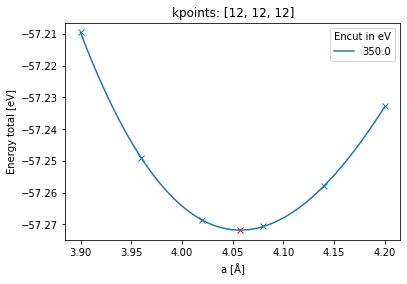

In [32]:
#%%time

poly_deg = 3

unique_kpts = np.unique(df_result.kpoints.to_list(), axis=0)
fig, ax_list = plt.subplots(ncols=len(unique_kpts), sharey=True, sharex=True)

concat_list = [df_result]
for i, kpt in enumerate(unique_kpts):
    if isinstance(ax_list, list):
        ax = ax_list[i]
        ax_list[0].set_ylabel("Energy total [eV]")
    else:
        ax = ax_list
        ax.set_ylabel("Energy total [eV]")
    
    kpt = kpt.tolist()
    df_kpt = df_result[df_result.kpoints.astype(str) == str(kpt)]
    for encut in np.unique(df_kpt.encut.tolist()):
        df_encut = df_kpt[df_kpt.encut==encut]
        a_array = np.array(df_encut.a.tolist())
        args = np.argsort(a_array)
        a_array = a_array[args]
        energy_array = np.array(df_encut.e_tot.tolist())[args]
        poly = np.polyfit(a_array, energy_array, deg=poly_deg)
        a_fit = np.linspace(a_array.min(), a_array.max(), 1001)
        e_tot_fit = np.poly1d(poly)(a_fit)
        e_eq = e_tot_fit[np.argmin(e_tot_fit)]
        a_eq = a_fit[np.argmin(e_tot_fit)]
        df_encut["e_eq"] = e_eq
        df_encut["a_eq"] = a_eq
        concat_list.append(df_encut)
        ax.plot(a_eq, e_eq, "rx")
        ax.plot(a_array, energy_array, "x")
        color = ax.get_lines()[-1].get_color()
        ax.plot(a_fit, e_tot_fit, color=color, label="{}".format(encut))
        ax.set_xlabel("a [$\mathrm{\AA}$]")
        ax.set_title("kpoints: {}".format(str(kpt)))
plt.legend(ncol=2, title="Encut in eV")